In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import shapiro, kurtosis, skew
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer

In [65]:
#5 ptos Cargar la base de datos kmeans1.csv utilizando pandas.

df=pd.read_csv("kmeans.1.csv")


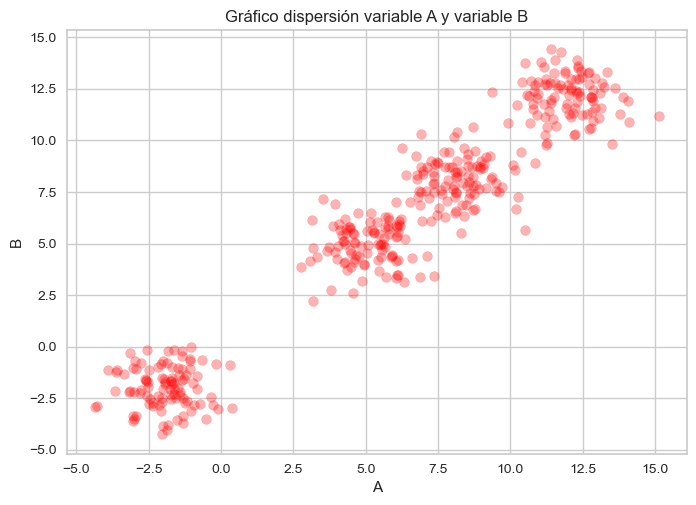

In [66]:
#5 ptos Por medio de matplotlib (o seaborn) genere un gr´afico de dispersi´on (scatter plot) de las variablesA y B.

grafico=plt.scatter(df["A"], df["B"], color="red", alpha=0.3)
plt.title("Gráfico dispersión variable A y variable B")
plt.xlabel("A")
plt.ylabel("B")
plt.grid(True)
plt.savefig(f"Gráfico dispersión A-B.png")

K means con un solo K

In [ ]:
#5 ptos Aplique el algoritmo k-means (from sklearn.cluster import KMeans), observe y analice los outputsdisponibles (centroides, clusters asignados y distancia dentro de las clases).

kmeans1 = KMeans(n_clusters=5, random_state=25)
kmeans1.fit(df)

kmeans1.inertia_

#Centroides:

centroides1= kmeans1.cluster_centers_


print(centroides1)

#Clusters asignados.

asignaciones= kmeans1.labels_

#Distancia:

distancias = kmeans1.transform(df)

In [ ]:
#Visualización centroides.

plt.scatter(df["A"], df["B"], color="red", alpha=1, label="Datos originales")
plt.scatter(centroides1[:, 0], centroides1[:, 1], color="blue", alpha=1, label="Centroides1")

plt.title("Gráfico comparativo datos originales y centroides1")
plt.xlabel("A")
plt.ylabel("B")
plt.grid(True)
plt.legend()

plt.savefig(f"Gráfico_centroides1.png")


In [ ]:
#Clusters asignados

pd.Series(asignaciones).value_counts().sort_values()

In [ ]:
#Distancias.

distancia_intra=distancias.min(axis=1)

#print(distancia_intra.mean())

#Distancia para varios clusters.

distancia_promedio={}

for cluster in range(kmeans1.n_clusters):
    puntos=distancias[asignaciones== cluster, cluster]
    distancia_promedio_grupo= np.mean(puntos)
    distancia_promedio[cluster]=distancia_promedio_grupo

df_distancia_promedio = pd.DataFrame.from_dict(distancia_promedio, orient='index', columns=['Distancia promedio'])

k-means con varios K.

In [ ]:
#Probamos con varias K.

dist_interclases = {}
K2 = range(1, 10)

for k in K2:
    kmeans2 = KMeans(n_clusters=k, random_state=25)
    kmeans2.fit(df)
    dist_interclases[k] = kmeans2.inertia_

df_interclase = pd.DataFrame.from_dict(dist_interclases, orient='index', columns=['Distancia promedio']).reset_index()
df_interclase.columns=["N_clusters", "Dist_interclase"]

In [ ]:
plt.plot(df_interclase['N_clusters'], df_interclase['Dist_interclase'], marker="o", linestyle="-", color="blue")
plt.title("Comparación entre número de clusters y distancia interclase")
plt.xlabel("Número de clusters")
plt.ylabel("Distancia interclase")
plt.grid(True)

plt.savefig("Gráfico comparativo n clusters y distancia interclase.png")

In [ ]:
df_interclase

Parte 2

In [68]:
#Esto servirá como instancia para todos los análisis de más abajo. En la futura gran clase implementaré la importación directa, pero por tiempo lo dejo pendiente.
df2=pd.read_csv("kmeans2.csv")

Escalamiento de la base de datos con un minmax

In [ ]:
#Esto podría hacerse con la clase que hice más abajo, pero lo dejo por la organicidad de las instrucciones.

escalador=MinMaxScaler()
df_escalado=escalador.fit_transform(df2)

In [ ]:
#Reciclamos el código anterior pra trabajar con varios K

dist_interclases4 = {}
dbi_scores4={}

#Me da problemas con el 1 en el rango del k, por lo que aumento a un rango de 2 a 10.
K4 = range(2, 11)

for k in K4:
    kmeans4 = KMeans(n_clusters=k, random_state=25)
    kmeans4.fit(df_escalado)
    dist_interclases4[k] = kmeans4.inertia_
    etiquetas = kmeans4.labels_
    dbi = davies_bouldin_score(df_escalado, etiquetas)
    dbi_scores4[k] = dbi

df_interclase4 = pd.DataFrame.from_dict(dist_interclases4, orient='index', columns=['Distancia promedio']).reset_index()
df_interclase4.columns=["N_clusters", "Dist_interclase"]

#No me dejó convertirlo, tuve que improvizar una forma que n osé si es la mejor, pero funciona.
df_dbi4 = pd.DataFrame(list(dbi_scores4.items()), columns=['N_clusters', 'DBI'])

In [ ]:
plt.plot(df_dbi4['N_clusters'], df_dbi4['DBI'], marker="o", linestyle="-", color="green")
plt.title("Comparación entre número de clusters y DBI")
plt.xlabel("Número de clusters")
plt.ylabel("DBI")
plt.grid(True)

plt.savefig("Gráfico comparativo n clusters y DBI.png")

Con base en el dataframe y el gráfico de DBI, es posible afirmar que el número más adecuado de clusters para los datos es 5.

Función automatizadora

In [ ]:
#Más abajo integro estas funciones en una clase, pero dejo las originales por las modificaciones que se deben hacer de ellas cuando se integran a la clase. Por si las moscas.

def estandarizadora(df, descriptores, estrategias):
    #podemos reciclar desde las imputaciones
    df_estandarizado =df.copy(deep=True)
    #nos aseguramos que las listas de descriptores y estrategias tengan el mismo largo, también reciclado.
    if len(descriptores) != len(estrategias):
        raise ValueError("Las listas de descriptores y estrategias deben ser del mismo largo")
    
    for i, columna in enumerate(descriptores):
        if columna in df_estandarizado.columns:
            estrategia=estrategias[i]
            if estrategia == "z":
                scaler=StandardScaler()
                df_estandarizado[columna]=scaler.fit_transform(df_estandarizado[[columna]])
            elif estrategia == "minmax":
                scaler=MinMaxScaler()
                df_estandarizado[columna]=scaler.fit_transform(df_estandarizado[[columna]])
            elif estrategia == "logaritmica":
                scaler = PowerTransformer(method='yeo-johnson')
                df_estandarizado[columna]=scaler.fit_transform(df_estandarizado[[columna]])
            elif estrategia == "robust":
                scaler = RobustScaler()
                df_estandarizado[columna] = scaler.fit_transform(df_estandarizado[[columna]])
            else:
                print("Debe ser estandarización Z, tipo Minmax, logarítmica o robusta")
        else:
            print("Columna no encontrada en el dataframe")
    return df_estandarizado

def metricas_k(df):
    dist_interclases = {}
    dbi_scores={}


    K = range(2, 11)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=25)
        kmeans.fit(df)
        dist_interclases[k] =   kmeans.inertia_
        etiquetas = kmeans.labels_
        dbi = davies_bouldin_score(df, etiquetas)
        dbi_scores[k] = dbi

    df_interclase = pd.DataFrame.from_dict(dist_interclases4, orient='index', columns=['Distancia promedio']).reset_index()
    df_interclase.columns=["N_clusters", "Dist_interclase"]

#No me dejó convertirlo, tuve que improvizar una forma que n osé si es la mejor, pero funciona.
    df_dbi = pd.DataFrame(list(dbi_scores.items()), columns=['N_clusters', 'DBI'])

    return df_interclase, df_dbi

def graficadora(cluster, metrica):
    plt.plot(cluster, metrica, marker="o", color="red", linestyle="-")
    plt.title(f"Gráfico comparativo entre {cluster} y {metrica}")
    plt.xlabel(f"Número de clusters")
    plt.ylabel(f"{metrica}")
    plt.grid(True)
    plt.savefig(f"gráfico comparativo número de clusters, métrica de evaluación.png")

In [ ]:
class kmeans_procesamiento:
    def __init__(self, df):
        self.df = df

    def estandarizar(self, descriptores, estrategias):
        df_estandarizado = self.df.copy(deep=True)

        if len(descriptores) != len(estrategias):
            raise ValueError("Las listas de descriptores y estrategias deben ser del mismo largo")

        for i, columna in enumerate(descriptores):
            if columna in df_estandarizado.columns:
                estrategia = estrategias[i]
                if estrategia == "z":
                    scaler = StandardScaler()
                    df_estandarizado[columna] = scaler.fit_transform(df_estandarizado[[columna]])
                elif estrategia == "minmax":
                    scaler = MinMaxScaler()
                    df_estandarizado[columna] = scaler.fit_transform(df_estandarizado[[columna]])
                elif estrategia == "logaritmica":
                    scaler = PowerTransformer(method='yeo-johnson')
                    df_estandarizado[columna] = scaler.fit_transform(df_estandarizado[[columna]])
                elif estrategia == "robust":
                    scaler = RobustScaler()
                    df_estandarizado[columna] = scaler.fit_transform(df_estandarizado[[columna]])
                else:
                    print("Debe ser estandarización Z, tipo Minmax, logarítmica o robusta")
            else:
                print(f"Columna {columna} no encontrada en el dataframe")
        return df_estandarizado

    def metricas_k(self, df):
        dist_interclases = {}
        dbi_scores = {}

        K = range(2, 11) 

        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=25)
            kmeans.fit(df)
            dist_interclases[k] = kmeans.inertia_
            etiquetas = kmeans.labels_
            dbi = davies_bouldin_score(df, etiquetas)
            dbi_scores[k] = dbi

        # Creamos DataFrames para graficar 
        df_interclase = pd.DataFrame.from_dict(dist_interclases, orient='index', columns=['Distancia promedio']).reset_index()
        df_interclase.columns = ["N_clusters", "Dist_interclase"]

        #DBI
        df_dbi = pd.DataFrame(list(dbi_scores.items()), columns=['N_clusters', 'DBI'])

        return df_interclase, df_dbi

    def graficar(self, df_interclase, df_dbi):
            # Gráfico de distancia intra-cluster
        plt.figure(figsize=(10, 5))
        plt.plot(df_interclase['N_clusters'], df_interclase['Dist_interclase'], marker="o", color="red", linestyle="-")
        plt.title("Distancia Intra-cluster vs Número de Clusters")
        plt.xlabel("Número de Clusters")
        plt.ylabel("Distancia Intra-cluster")
        plt.grid(True)
        plt.savefig("distancia_intra_cluster.png")
        plt.show()

        #DBI
        plt.figure(figsize=(10, 5))
        plt.plot(df_dbi['N_clusters'], df_dbi['DBI'], marker="o", color="blue", linestyle="-")
        plt.title("Davies-Bouldin Index vs Número de Clusters")
        plt.xlabel("Número de Clusters")
        plt.ylabel("DBI")
        plt.grid(True)
        plt.savefig("davies_bouldin_index.png")
        plt.show()

    def ejecutar_proceso(self, descriptores, estrategias):
        
        # Estandarizar el DataFrame
        df_estandarizado = self.estandarizar(descriptores, estrategias)

        #Calcular las métricas de KMeans
        df_interclase, df_dbi = self.metricas_k(df_estandarizado)

        #Graficar las métricas
        self.graficar(df_interclase, df_dbi)

In [ ]:
#Dejo los descriptores y lista para ir trabajando con distintos métodos de estandarización si fuera necesario. Por ahora en la mayoría es minmax. Por cuestiones de tiempo no puedo probar otros ahora, pero la versión de github tendrá algunas pruebas adicionales.

descriptores=['PAC_EDAD', 'SATO2', 'TEMPERATURA', 'GLASGOW', 'EVA', 'HGT', 'FR', 'DIAS_HOSP']

estrategias=["minmax", "minmax", "minmax", "minmax", "minmax", "minmax", "minmax", "minmax"]

In [ ]:
#Esto cuando queremos ejecutar todo el código, normalmente para ver los gráficos de una vez. De cualquier forma fueron creados métodos individuales para ejecutar cada proceso e ir viendo como van las cosas.


analisis=kmeans_procesamiento(df2)

#Como podría usar más de un tipo de escalamiento/estandarización, no me sirve para la última de la dos. Voy a tener que modificar el asunto y usar una nueva función.
df_estandarizado=analisis.estandarizar(descriptores, estrategias)
interclase, dbi=analisis.metricas_k(df_estandarizado)

función para interpretar centroides

In [64]:
#Estas se fusionan en una clase más abajo, pero las dejo como arqueología del código

def ejecucion_kmeans(df, tipo_escalamiento, k):
    df=df.copy(deep=True)
    scaler=tipo_escalamiento
    df_escalado=scaler5.fit_transform(df)

    kmeans=KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_escalado)

    return kmeans


def interpretar_centroides(kmeans, tipo_escalamiento, df_bruto):
    centroides_escalados = kmeans.cluster_centers_
    #Esto lo agrego por si algún día revisamos variables normales en cuanto a su distribución
    if isinstance(tipo_escalamiento, StandardScaler):
        centroides_originales = scaler.inverse_transform(centroides_escalados)
    elif isinstance(tipo_escalamiento, MinMaxScaler):
        centroides_originales = scaler.inverse_transform(centroides_escalados)
        
    else:
        raise ValueError("El tipo de escalamiento no es reconocido. Usa StandardScaler o MinMaxScaler.")

    return centroides_originales

In [ ]:
scaler5=MinMaxScaler()
df2_escalado=scaler5.fit_transform(df2)


#Ponemos cinco por la ejecución, además de cinco clusters porque ese es el número adecuado según DBI
kmeans5=KMeans(n_clusters=5, random_state=42)
kmeans5.fit(df2_escalado)

KMeans(n_clusters=5, random_state=42)

In [48]:
centroides_escalados = kmeans5.cluster_centers_

Usamos nuestra función de centroides

In [49]:
centroides_originales = interpretar_centroides(kmeans5, scaler5, df2)

In [50]:
print(centroides_escalados[0])
print(centroides_originales[0])

[0.08506599 0.97485769 0.35541626 0.99898568 0.28410278 0.22323475
 0.15997463 0.00765235]
[ 11.568974    97.48576873  36.84333005  14.98782812   3.55692506
 142.26203356  18.35756439   1.59168869]


nueva clase para interpretar los centroides

In [60]:
#Empezamos con el escalador. En el futuro admitirá más, pero por el tiempo es solo Minmax y el Z.
class procesamiento_kmeans:
    def __init__(self, tipo_escalamiento):
        
        if not isinstance(tipo_escalamiento, (MinMaxScaler, StandardScaler)):
            raise ValueError("El tipo de escalamiento debe ser MinMaxScaler o StandardScaler.")
        self.escalador = tipo_escalamiento
        self.kmeans = None
        self.df_escalado = None

    def ejecutar_kmeans(self, df, k):
        
        # Escalar los datos
        df = df.copy(deep=True)
        self.df_escalado = self.escalador.fit_transform(df)
        
        # Ajustar KMeans
        self.kmeans = KMeans(n_clusters=k, random_state=42)
        self.kmeans.fit(self.df_escalado)
#Retornamos lo necesario para la función de los centroides.
        return self.kmeans

    def interpretar_centroides(self, df_bruto):
        
        if self.kmeans is None:
            raise ValueError("Primero hay que ejecutar el método `ejecutar_kmeans` para generar el insumo.")

        centroides_escalados = self.kmeans.cluster_centers_

        # Transformar los centroides a su escala original con el método inverso. No innovamso en nada, todo está en el paquete
        if isinstance(self.escalador, (MinMaxScaler, StandardScaler)):
            centroides_originales = self.escalador.inverse_transform(centroides_escalados)
        else:
            raise ValueError("El tipo de escalamiento no es reconocido.")
        
        return centroides_escalados, centroides_originales

    def analizar_clusters(self, df):
        
        if self.kmeans is None:
            raise ValueError("Primero hay que ejecutar el método `ejecutar_kmeans` para que se produzca el insumo.")
        
        # Agregar las etiquetas de los cluster al DataFrame original
        etiquetas = self.kmeans.labels_
        df['Cluster'] = etiquetas

        # Calcular estadísticas descriptivas por cluster. Todo un asunto para llegar aquí, pero resulta mucho más simple con el resumen
        resumen = df.groupby('Cluster').agg(['mean', 'median', 'std', 'min', 'max'])
        
        return resumen


In [ ]:
analisis_centroide=procesamiento_kmeans(MinMaxScaler())
#Aquí el dataframe y el número de clusters, como ya vimos, 5 es el número. Voy a dejar que se instancie el dataframe, en el futuro agregaré el código para poder importarlo desde la clase.
kmeans_1= analisis_centroide.ejecutar_kmeans(df2, 5)

#Con esto podríamos graficar, pero son muchas dimensiones, habría que poner un PCA y ver que pasa
centroides_escalados, centroides_originales=analisis_centroide.interpretar_centroides(df2)

#Esto sirve, es estadísticabásica sobre los clusters. Una información que podría acompañar a los hipotéticos gráficos
resumen_clusters=analisis_centroide.analizar_clusters(df2)

In [70]:
resumen_clusters.to_excel("resumen_clusters.xlsx")